# MULTIPLE LINEAR REGRESSION
*Task is to perform a multiple linear regression analysis to predict the price of Toyota corolla based on the given attributes.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

import statsmodels.api as sm
import joblib

In [3]:
# statsmodels for rich summary
#import statsmodels.api as sm

#Read the data
df = pd.read_csv(r"ToyotaCorolla - MLR.csv")

In [4]:
# Normalize column names to make downstream code robust
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

In [5]:
# Exploratory Data Analysis (EDA)
# Summary statistics
print("Columns found:", df.columns.tolist())
print("Sample rows:\n", df.head(3))

Columns found: ['price', 'age_08_04', 'km', 'fuel_type', 'hp', 'automatic', 'cc', 'doors', 'cylinders', 'gears', 'weight']
Sample rows:
    price  age_08_04     km fuel_type  hp  automatic    cc  doors  cylinders  \
0  13500         23  46986    Diesel  90          0  2000      3          4   
1  13750         23  72937    Diesel  90          0  2000      3          4   
2  13950         24  41711    Diesel  90          0  2000      3          4   

   gears  weight  
0      5    1165  
1      5    1165  
2      5    1165  


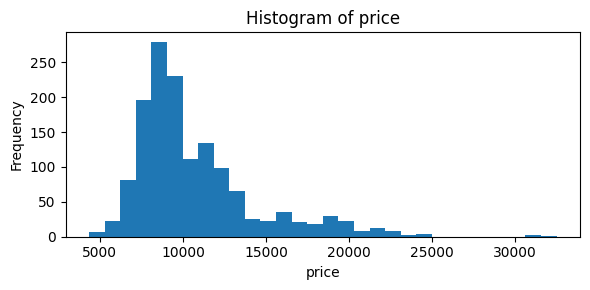

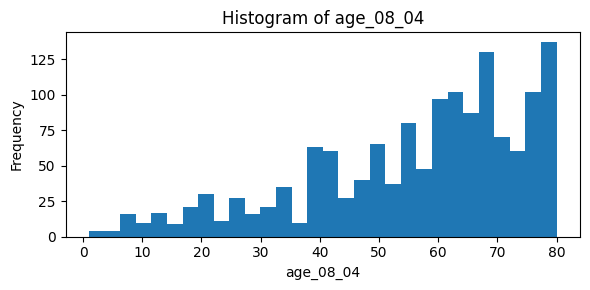

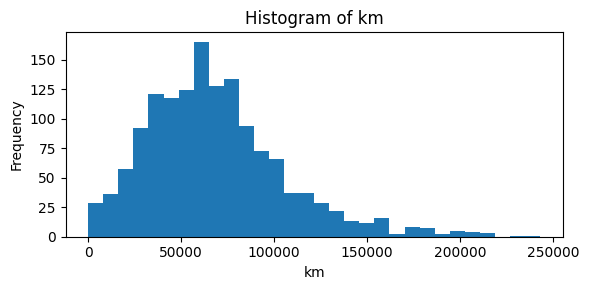

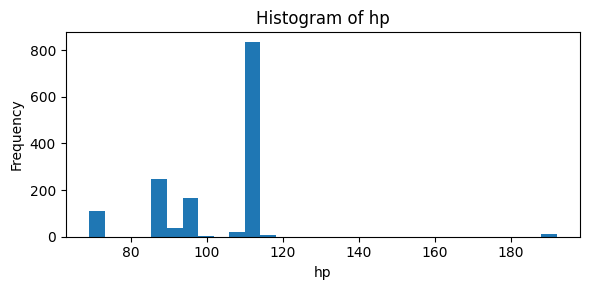

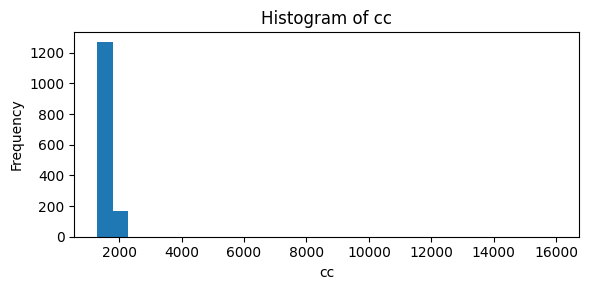

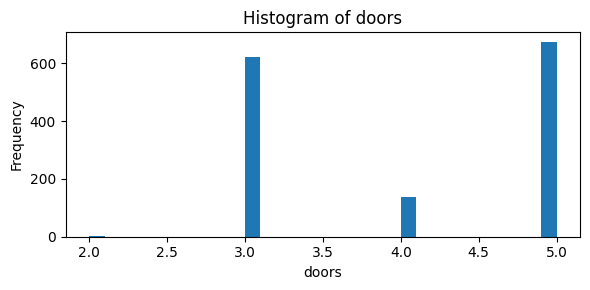

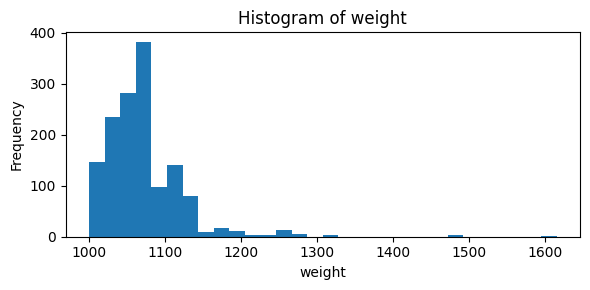

In [36]:
# Distribution plots for numeric features

numeric_cols = ['price', 'age_08_04', 'km', 'hp', 'cc', 'doors', 'weight']

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

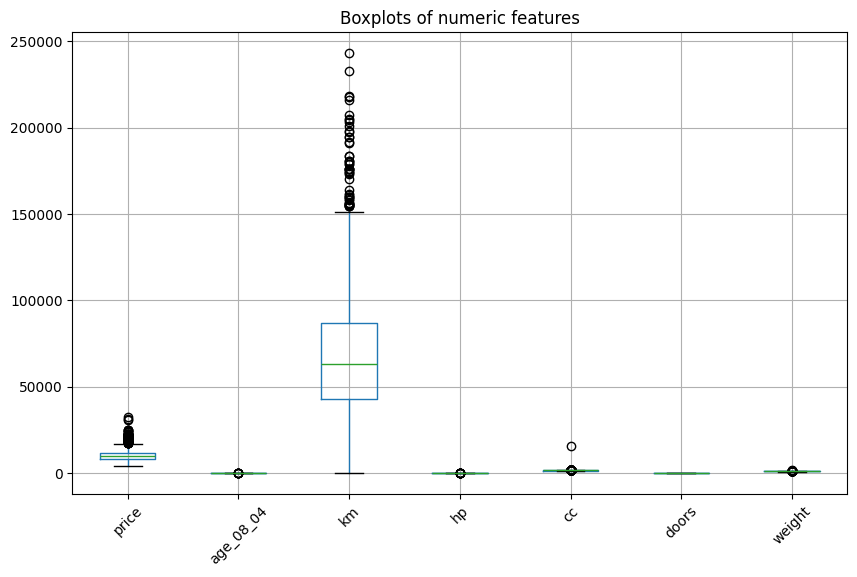

In [38]:
# Boxplots to reveal outliers

plt.figure(figsize=(10,6))
df[numeric_cols].boxplot()
plt.title("Boxplots of numeric features")
plt.xticks(rotation=45)
plt.show()


--- Correlation matrix (numeric) ---

              price  age_08_04        km        hp        cc     doors  \
price      1.000000  -0.876590 -0.569960  0.314990  0.126389  0.185326   
age_08_04 -0.876590   1.000000  0.505672 -0.156622 -0.098084 -0.148359   
km        -0.569960   0.505672  1.000000 -0.333538  0.102683 -0.036197   
hp         0.314990  -0.156622 -0.333538  1.000000  0.035856  0.092424   
cc         0.126389  -0.098084  0.102683  0.035856  1.000000  0.079903   
doors      0.185326  -0.148359 -0.036197  0.092424  0.079903  1.000000   
weight     0.581198  -0.470253 -0.028598  0.089614  0.335637  0.302618   

             weight  
price      0.581198  
age_08_04 -0.470253  
km        -0.028598  
hp         0.089614  
cc         0.335637  
doors      0.302618  
weight     1.000000  


<Figure size 800x600 with 0 Axes>

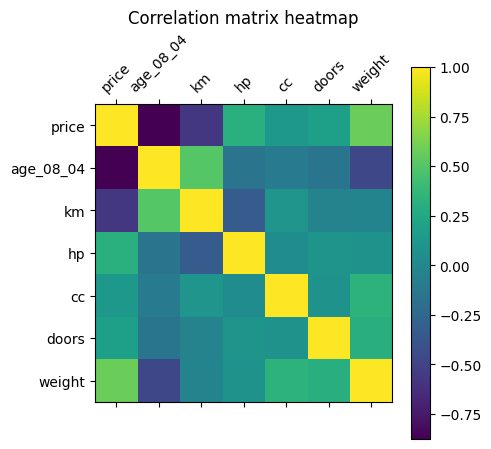

In [37]:
# Correlation matrix
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
print("\n--- Correlation matrix (numeric) ---\n")
print(corr)

plt.matshow(corr)
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation matrix heatmap')
plt.show()

In [6]:
# Prepare X, y 
TARGET = 'price'
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in dataframe. Found columns: {df.columns.tolist()}")

X = df.drop(columns=[TARGET])
y = df[TARGET]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age_08_04  1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   cc         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Cylinders  1436 non-null   int64 
 9   Gears      1436 non-null   int64 
 10  Weight     1436 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 123.5+ KB


In [7]:
# Auto-detect numeric & categorical features
# Remove obvious non-feature columns if present
non_feature_candidates = ['id', 'index']
for c in non_feature_candidates:
    if c in X.columns:
        X = X.drop(columns=[c])

numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_include=object)

numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)

print("Detected numeric features:", numeric_features)
print("Detected categorical features:", categorical_features)


Detected numeric features: ['age_08_04', 'km', 'hp', 'automatic', 'cc', 'doors', 'cylinders', 'gears', 'weight']
Detected categorical features: ['fuel_type']


In [8]:
# Preprocessor 
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)], remainder='drop')

In [11]:
# get feature names after ColumnTransformer
def feature_names_from_column_transformer(ct, numeric_features, categorical_features):
    """Return list of feature names after ColumnTransformer transformation."""
    feature_names = []
    # numeric features:
    feature_names.extend(list(numeric_features))
    # categorical: 
    if 'cat' in ct.named_transformers_ and hasattr(ct.named_transformers_['cat'], 'named_steps'):
        ohe = ct.named_transformers_['cat'].named_steps['onehot']
        try:
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        except Exception:
            cat_names = []
            for i, cats in enumerate(ohe.categories_):
                base = categorical_features[i]
                cat_names.extend([f"{base}_{c}" for c in cats[1:]])  # drop='first'
        feature_names.extend(cat_names)
    return feature_names

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# Model 1: Linear Regression pipeline -----
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipe_lr.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# Evaluation utils (version-safe RMSE)
def eval_reg(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: {y_true.shape} vs {y_pred.shape}")
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # version independent
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

y_pred = pipe_lr.predict(X_test)
metrics1 = eval_reg(y_test, y_pred)
print('\n Model 1: metrics (LinearRegression, all features)')
print(metrics1)


 Model 1: metrics (LinearRegression, all features)
{'MAE': 990.8872739193968, 'RMSE': np.float64(1484.2654153296517), 'R2': 0.8348888040611082}


In [18]:
# Statsmodels OLS summary for interpretation -----
# Fit preprocessor on full train to get transformed matrix
X_train_trans = preprocessor.fit_transform(X_train)
feature_names = get_feature_names_from_column_transformer(preprocessor, numeric_features, categorical_features)

In [19]:
# Add constant and run OLS (ensure shapes line up)
X_train_sm = sm.add_constant(pd.DataFrame(X_train_trans, columns=feature_names))
ols_model = sm.OLS(y_train.values, X_train_sm).fit()
print('\n--- Statsmodels OLS summary (Model 1) ---')
print(ols_model.summary())


--- Statsmodels OLS summary (Model 1) ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     762.7
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:43:29   Log-Likelihood:                -9863.2
No. Observations:                1148   AIC:                         1.975e+04
Df Residuals:                    1137   BIC:                         1.980e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [21]:
# Backward elimination using p-values
def backward_elimination(X_df, y_series, alpha=0.05):
    X0 = X_df.copy()
    X0 = sm.add_constant(X0)
    while True:
        model = sm.OLS(y_series, X0).fit()
        pvalues = model.pvalues.drop('const', errors='ignore')
        if pvalues.empty:
            break
        max_p = pvalues.max()
        if max_p > alpha:
            drop_feat = pvalues.idxmax()
            print(f"Dropping {drop_feat} with p={max_p:.4f}")
            X0 = X0.drop(columns=[drop_feat])
        else:
            break
    return model, X0.columns.drop('const', errors='ignore').tolist()

X_be = pd.DataFrame(X_train_trans, columns=feature_names)
model_be, selected_features = backward_elimination(X_be, y_train.values, alpha=0.05)
print('\n Backward elimination selected features:')
print(selected_features)
print(model_be.summary())


Dropping fuel_type_Diesel with p=0.8611
Dropping cylinders with p=0.8681
Dropping cc with p=0.7165
Dropping automatic with p=0.3989
Dropping doors with p=0.1514

 Backward elimination selected features:
['age_08_04', 'km', 'hp', 'gears', 'weight', 'fuel_type_Petrol']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1272.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:44:41   Log-Likelihood:                -9864.7
No. Observations:                1148   AIC:                         1.974e+04
Df Residuals:                    1141   BIC:                         1.978e+04
Df Model:                           6                                         
Covariance Type:     

In [22]:
# Build sklearn pipeline that selects only selected features (by indices) -----
# Map selected features to indices in the transformed matrix
selected_indices = [feature_names.index(f) for f in selected_features]

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, indices):
        self.indices = indices
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # X expected as numpy array after transformer
        return X[:, self.indices]

pipe_be = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', ColumnSelector(selected_indices)),
    ('regressor', LinearRegression())
])
pipe_be.fit(X_train, y_train)
metrics2 = eval_reg(y_test, pipe_be.predict(X_test))
print('\n Model 2: metrics (Backward elimination) ')
print(metrics2)


 Model 2: metrics (Backward elimination) 
{'MAE': 997.8091461706515, 'RMSE': np.float64(1483.1498814137437), 'R2': 0.8351368970531263}


In [25]:
# Model 3: log-transform target 
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

pipe_log = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipe_log.fit(X_train, y_train_log)

y_pred_log = pipe_log.predict(X_test)
y_pred_log_inv = np.expm1(y_pred_log)
metrics3 = eval_reg(y_test, y_pred_log_inv)
print('\n Model 3: metrics (Log-transform on target) ')
print(metrics3)



 Model 3: metrics (Log-transform on target) 
{'MAE': 863.0008847602019, 'RMSE': np.float64(1257.7153735930299), 'R2': 0.8814454774408771}


In [26]:
# Regularization: Lasso and Ridge with GridSearchCV 
alphas = np.logspace(-3, 3, 30)
pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor), ('reg', Lasso(max_iter=5000))])
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor), ('reg', Ridge(max_iter=5000))])
param_grid = {'reg__alpha': alphas}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
# Using neg_mean_squared_error for compatibility and convert later
search_lasso = GridSearchCV(pipe_lasso, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
search_ridge = GridSearchCV(pipe_ridge, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

search_lasso.fit(X_train, y_train)
search_ridge.fit(X_train, y_train)

best_alpha_lasso = search_lasso.best_params_['reg__alpha']
best_alpha_ridge = search_ridge.best_params_['reg__alpha']
print('\nBest Lasso alpha:', best_alpha_lasso)
print('Best Ridge alpha:', best_alpha_ridge)



Best Lasso alpha: 92.36708571873865
Best Ridge alpha: 148.73521072935117


In [30]:
# Evaluate on test set
y_pred_lasso = search_lasso.predict(X_test)
y_pred_ridge = search_ridge.predict(X_test)
metrics_lasso = eval_reg(y_test, y_pred_lasso)
metrics_ridge = eval_reg(y_test, y_pred_ridge)

print('\n Lasso metrics ')
print(metrics_lasso)
print('\n Ridge metrics ')
print(metrics_ridge)



 Lasso metrics 
{'MAE': 994.5122600224308, 'RMSE': np.float64(1409.4958855466432), 'R2': 0.8511046922315125}

 Ridge metrics 
{'MAE': 1001.0918713121197, 'RMSE': np.float64(1440.4008773026474), 'R2': 0.8445036707364527}


In [31]:
# Feature importance from best Ridge (coefficients) 
# fit preprocessor on whole training set to get feature names
preprocessor.fit(X_train)
X_full_trans = preprocessor.transform(X_train)
feat_names = get_feature_names_from_column_transformer(preprocessor, numeric_features, categorical_features)

ridge_coef = pd.Series(search_ridge.best_estimator_.named_steps['reg'].coef_, index=feat_names)
print('\nTop ridge coefficients by absolute value:')
print(ridge_coef.abs().sort_values(ascending=False).head(10))



Top ridge coefficients by absolute value:
age_08_04           1987.726604
weight              1038.144400
km                   781.466387
hp                   350.696719
fuel_type_Petrol     169.817201
gears                114.444022
fuel_type_Diesel      79.620199
automatic             54.533294
doors                 32.151918
cc                     5.649522
dtype: float64


In [32]:
# Compare RMSEs and pick best model 
all_metrics = {'Model1': metrics1['RMSE'], 'Model2': metrics2['RMSE'], 'Model3': metrics3['RMSE'],
               'Lasso': metrics_lasso['RMSE'], 'Ridge': metrics_ridge['RMSE']}
print('\nRMSE comparison:', all_metrics)

best_model_name = min(all_metrics, key=all_metrics.get)
if best_model_name == 'Model1':
    best_model = pipe_lr
elif best_model_name == 'Model2':
    best_model = pipe_be
elif best_model_name == 'Model3':
    best_model = pipe_log
elif best_model_name == 'Lasso':
    best_model = search_lasso.best_estimator_
else:
    best_model = search_ridge.best_estimator_

print('\nSelected best model:', best_model_name)


RMSE comparison: {'Model1': np.float64(1484.2654153296517), 'Model2': np.float64(1483.1498814137437), 'Model3': np.float64(1257.7153735930299), 'Lasso': np.float64(1409.4958855466432), 'Ridge': np.float64(1440.4008773026474)}

Selected best model: Model3


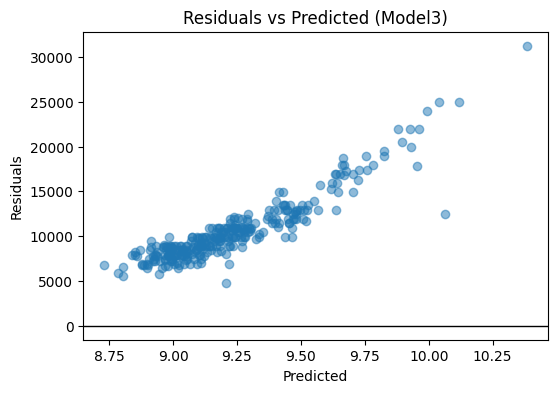

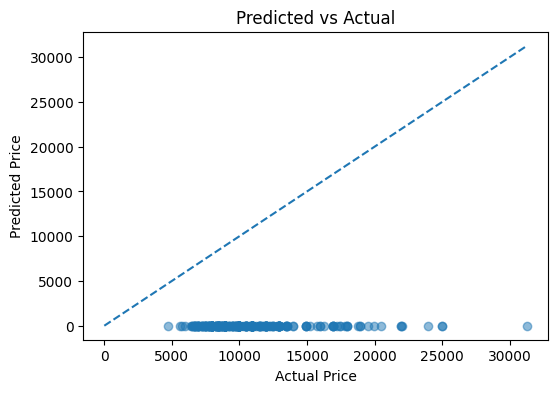

In [33]:
# Residual plot for model
yhat = best_model.predict(X_test)
resid = y_test - yhat
plt.figure(figsize=(6,4))
plt.scatter(yhat, resid, alpha=0.5)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title(f'Residuals vs Predicted ({best_model_name})')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_test, yhat, alpha=0.5)
m = min(y_test.min(), yhat.min()); M = max(y_test.max(), yhat.max())
plt.plot([m, M], [m, M], '--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual')
plt.show()


In [34]:
# final model 
joblib.dump(best_model, 'toyota_price_model_best.pkl')
print('\nSaved best model to toyota_price_model_best.pkl')


Saved best model to toyota_price_model_best.pkl


# Interview Questions:
# 1.What is Normalization & Standardization and how is it helpful?
-> **Normalization:**
Normalization rescales data to a fixed range — typically 0 to 1. Using the minimum and maximum values of the feature. Useful when data distribution isn't known or isn't normal, or for algorithms sensitive to input range like Neural Networks and k-NN.
Helpful to:
Prevents large-scale features from dominating smaller-scale ones.
Speeds up training.
Helps models converge more reliably.
Increases accuracy for distance-based methods.

-> **Standardization (Z-Score Scaling):**
Transforms data to have a mean (μ) of 0 and a standard deviation (σ) of 1. Useful when data is normally distributed (Gaussian), or for algorithms like Logistic Regression, SVM, PCA that assume zero mean and unit variance.
Helpful to:
Ensures all features contribute equally.
Prevents coefficients from exploding.
Eliminates bias due to different units.
Leads to better and more stable training performance.

# 2.What techniques can be used to address multicollinearity in multiple linear regression?
->
**1.Ridge Regression (L2 Regularization):**
Shrinks coefficients of correlated variables.
Does not remove predictors but stabilizes coefficients.
Best when you want to keep all variables.

**2.Lasso Regression (L1 Regularization):**
Performs feature selection by shrinking some coefficients to zero.
Useful for high-dimensional datasets.
Can remove redundant and collinear predictors.

**3.Remove Highly Correlated Predictors:**
Drop one of the correlated variables.
Use the correlation matrix or Variance Inflation Factor (VIF) to identify problematic predictors.
Threshold rule: VIF > 10 (or even > 5) indicates multicollinearity.

**4.Principal Component Regression (PCR):**
Apply PCA to transform correlated predictors into uncorrelated principal components.
Then fit regression on these components.
Removes multicollinearity but reduces interpretability.

**5.Increase the Sample Size:**
More data reduces variance in coefficient estimates.
Helps mitigate instability caused by multicollinearity.
Not always feasible, but statistically effective.

**6.Center or Standardize Variables:**
Scaling doesn’t remove multicollinearity, but it helps numerical stability.
Makes models easier to interpret and reduces issues in polynomial models.
